# Constants

In [34]:
G = 9.8 # m/s

class Engine:
    mass: float # tons
    thrust: float # kN
    isp: float # sec
    struct_frac: float

class DiscreteSolidEngine(Engine):
    m_struct: float # tons
    m_fpe: float # tons

SWIVEL = Engine()
SWIVEL.mass = 1.5
SWIVEL.thrust = 168
SWIVEL.isp = 250
SWIVEL.struct_frac = 0.125

THUMPER = DiscreteSolidEngine()
THUMPER.mass = 0
THUMPER.thrust = 250
THUMPER.isp = 175
THUMPER.m_struct = 1.5
THUMPER.m_fpe = 6.15

# Thumper has 6.15 tons of fuel, total mass 7.65
THUMPER_FUEL_MASS = 6.15
THUMPER_WET_MASS = 7.65
THUMPER.struct_frac = (THUMPER_WET_MASS - THUMPER_FUEL_MASS) / THUMPER_WET_MASS

ISP_SWIVEL = 250 # sec
ISP_THUMPER = 175 # sec
ISP = [ISP_SWIVEL, ISP_THUMPER]

M_ENGINES = [1.5, 0] # tons

# Stages

To plan a stage, we start with a desired $\Delta v$ for the stage, and an engine with a given specific impulse $I_{sp}$. We then compute the amount $m_f$ of fuel needed to achieve it.

Our definition of dry mass $m_d$ will differ depending on the type of the stage. But we can define wet mass $m_w$:

$$
\begin{align}
m_w &= m_d + m_f \tag{2}
\end{align}
$$

From rocket theory, we have:

$$
\begin{align}
R &= e^{\frac{\Delta v}{I_{sp} \cdot g}} \tag{3} \\
  &= \frac{m_w}{m_d} \tag{4}
\end{align}
$$

We first compute the desired mass ratio $R$ with equation 3. We then find the amount of fuel $m_f$ that gives us our desired $\Delta v$.

In [35]:
import math
from typing import Optional, Sequence

class Stage[E: Engine]:
    def __init__(self, engine: E):
        self.delta_v_target: float = 0
        self.m_payload: float = 0
        self.engine = engine

    @property
    def v_e(self) -> float:
        '''
        Exhaust velocity.
        '''
        return self.engine.isp * G
    
    @property
    def r_target(self) -> float:
        '''
        Mass ratio needed to achieve self.delta_v_target.
        '''
        return math.exp(self.delta_v_target / self.v_e)
    
    @property
    def m_fuel(self) -> float:
        '''
        Fuel mass (tons) needed to achieve self.delta_v_target.
        '''
        raise NotImplementedError()
    
    @property
    def m_struct(self) -> float:
        '''
        Structural mass (tons) needed to achieve self.delta_v_target.
        '''
        raise NotImplementedError()
    
    @property
    def m_dry(self) -> float:
        '''
        Dry mass (tons).
        '''
        return self.m_struct + self.m_payload + self.engine.mass
    
    @property
    def m_wet(self) -> float:
        '''
        Wet mass (tons).
        '''
        return self.m_dry + self.m_fuel
    
    @property
    def twr(self) -> float:
        '''
        Thrust-to-weight ratio.
        '''
        thrust_newtons = self.engine.thrust
        weight_newtons = self.m_wet * G
        return thrust_newtons/weight_newtons
    
    @property
    def r_actual(self) -> float:
        '''
        Actual mass ratio.
        '''
        return self.m_wet / self.m_dry
    
    @property
    def delta_v_actual(self) -> float:
        '''
        Actual delta-V that we'll get with current self.v_e, self.m_wet, and self.m_dry.
        '''
        return self.v_e * math.log(self.m_wet / self.m_dry)

    def print(self) -> None:
        print(f"target R: {self.r_target:.1f}")
        print(f"actual R: {self.r_actual:.1f}")
        print(f"V_e: {self.v_e:.1f}")
        print(f"delta V: {self.delta_v_actual:.1f}")
        print(f"payload: {self.m_payload:.1f}")
        print(f"fuel: {self.m_fuel:.1f}")
        print(f"struct: {self.m_struct:.1f}")
        print(f"dry mass: {self.m_dry:.1f}")
        print(f"wet mass: {self.m_wet:.1f}")
        print(f"TWR: {self.twr:.1f}")

class Rocket:
    '''
    A rocket consists of stages. Stage 0 is the topmost (last) stage.
    '''

    def __init__(self, stages: Sequence[Stage]):
        self.stages = stages

    def set_delta_v_targets(self, delta_vs: Sequence[float]):
        '''
        Set the desired delta-Vs for each stage.
        '''
        for i in range(len(self.stages)):
            stage = self.stages[i]
            if i > 0:
                # Stage i's payload is stage i-1
                stage.m_payload = self.stages[i-1].m_wet
            stage.delta_v_target = delta_vs[i]

    @property
    def _lowest_active_stage(self) -> Optional[Stage]:
        '''
        Get the lowest stage with >0 target delta-V.
        (A stage may have 0 target delta-V, and in that case the stage is pretty much not there.)
        '''
        for stage in reversed(self.stages):
            if stage.delta_v_target > 0:
                return stage
        return None

    @property
    def m_wet(self) -> float:
        '''
        The rocket's wet mass (tons).
        '''
        active_stage = self._lowest_active_stage
        if active_stage is None:
            return 0
        return active_stage.m_wet

    @property
    def twr(self) -> float:
        active_stage = self._lowest_active_stage
        if active_stage is None:
            return 0
        return active_stage.twr

### Liquid-fuel rockets

For these rockets, dry mass $m_d$ consists of the payload $m_p$, the engine $m_e$, and some structural mass $m_s$:

$$
\begin{align}
m_d = m_p + m_e + m_s \tag{5}
\end{align}
$$

Each fuel tank has a dry mass, and the sum of this mass gives us the rocket's structural mass. We empirically find the ratio of each tank's structural mass to fuel mass, and note that the ratio holds for the whole rocket:

$$
\begin{align}
f_s = \frac{m_s}{m_f} \tag{6}
\end{align}
$$

Combining equations 2, 4, 5, and 6, we get:

$$
R = \frac{m_p + m_e + f_s m_f + m_f}{m_p + m_e + f_s m_f}
$$

Solving for $m_f$:

$$
m_f = \frac{(1-R)(m_p + m_e)}{f_s (R-1) - 1}
$$

We can now get $m_s$:

$$
m_s = f_s m_f
$$

### Example

<details>
Let:

$$
\begin{align*}
m_p &= 1.1 \text{ tons} \\
m_e &= 1.25 \text{ tons} \\
f_s &= 0.11 \\
I_{sp} &= 265 \text{s} \\
\text{desired } \Delta v &= 1,000 \text{ m/s}
\end{align*}
$$

Then:

$$
\begin{align*}
R &= 1.47 \\
m_f &= 1.06 \text{ tons} \\
m_s &= 0.117 \text{ tons}
\end{align*}
$$
</details>

In [36]:
class LiquidStage(Stage[Engine]):
    def __init__(self, engine: Engine):
        super().__init__(engine=engine)

    @property
    def m_fuel(self) -> float:
        return (1 - self.r_target) * (self.m_payload + self.engine.mass) / (self.engine.struct_frac * (self.r_target - 1) - 1)
    
    @property
    def m_struct(self) -> float:
        return self.engine.struct_frac * self.m_fuel

In [38]:
import unittest

class TestLiquidStage(unittest.TestCase):
    def test_m_fuel(self):
        # Set up
        engine = Engine()
        engine.isp = 265
        engine.mass = 1.25
        engine.struct_frac = 0.11

        stage = LiquidStage(engine)
        stage.delta_v_target = 1_000
        stage.m_payload = 1.1

        # Call
        m_fuel = stage.m_fuel

        # Test
        self.assertAlmostEqual(1.17, m_fuel, places=1)

unittest.main(argv=[''], verbosity=1, exit=False)

.F
FAIL: test_m_fuel (__main__.TestLiquidStage.test_m_fuel)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipykernel_2090/1072791956.py", line 19, in test_m_fuel
    self.assertAlmostEqual(1.17, m_fuel, places=2)
AssertionError: 1.17 != 1.163937190288626 within 2 places (0.006062809711373962 difference)

----------------------------------------------------------------------
Ran 2 tests in 0.002s

FAILED (failures=1)


### Solid-fuel rockets

For these, we have:

$$
\begin{align}
m_d = m_p + m_s \tag{7}
\end{align}
$$

$f_s$ is interpreted as the ratio of the structural mass to the wet mass:

$$
\begin{align}
f_s = \frac{m_s}{m_w} \tag{8}
\end{align}
$$

We find $f_s$ empirically.

We want to express $m_f$ in terms of the known quantities $m_p$, $R$, and $f_s$. Let's start with $m_d$. From equations 4, 7, and 8, we get:

$$
m_d = m_p + R f_s m_d
$$

Solving for $m_d$:

$$
m_d = -\frac{m_p}{R f_s - 1}
$$

From equations 2 and 4 we get:

$$
m_f = m_d(R - 1)
$$

From equations 4 and 6 we get:

$$
m_s = m_d R f_s
$$

In [29]:
class SolidStage(Stage[Engine]):
    def __init__(self, engine: Engine):
        super().__init__(engine=engine)
    
    @property
    def m_fuel(self) -> float:
        return - (self.m_payload * (self.r_target - 1)) / (self.r_target * self.engine.struct_frac - 1)
    
    @property
    def m_struct(self) -> float:
        return -(self.r_target * self.engine.struct_frac * self.m_payload) / (self.r_target * self.engine.struct_frac - 1)

## Discrete solid-fuel rockets

These rockets come a fixed-sized tubes with engines on the end. You can vary the amount of fuel inside, but the structural mass is fixed. You usually combine several of these rockets into one stage, so the planning questions are (1) how many rockets to use and (2) how much fuel to put in them.

We have:

$$
\begin{align}
m_d &= m_p + m_s n \tag{9} \\
n   &= \lceil \frac{m_f}{m_{fpe}} \rceil \notag
\end{align}
$$

where
- $m_d$ is the dry mass of the stage (tons)
- $m_s$ is the mass of a single rocket without fuel or payload (tons)
- $n$ is the number of rockets in the stage
- $m_{fpe}$ is the max amount of fuel a rocket can contain (tons)

You $m_p$, $m_s$, and $m_{fpe}$ empirically. The only thing missing is $m_f$.

From equations 2 and 4, we have:

$$
\begin{align*}
m_f &= m_w - m_d \\
    &= R m_d - m_d \\
    &= m_d (R - 1) 
\end{align*}
$$

This makes sense: $R$ reflects how much delta-V we want, and $m_d$ is the amount of mass (without fuel) we want to lift.

Substituting equation 9 for $m_d$:

$$
\begin{align}
m_f &= (m_p + m_s n) (R-1) \notag \\
    &= m_p (R-1) + m_s (R-1) n \notag
\end{align}
$$

Let's simplify a bit and let:

$$
\begin{align*}
r_p &= m_p (R-1) \\
r_s &= m_s (R-1)
\end{align*}
$$

(Note that these values are known.) $r_p$ is the payload mass scaled by the amount of wanted delta-V, and $r_s$ is the structural mass scaled in the same way.

So we have:

$$
\begin{align}
m_f &= r_p + r_s n \tag{10} \\
n   &= \lceil \frac{m_f}{m_{fpe}} \rceil \tag{11}
\end{align}
$$

So we need to find values of $m_f$ that satisfy equations 10 and 11.

Let's find some bounds on $m_f$. Since $n = \lceil m_f / m_{fpe} \rceil$, then $n$ is just the right number of tanks to give us at least $m_f$
tons of fuel:

$$
\begin{align*}
(n-1) m_{fpe} &< m_f &\leq n m_{fpe} \\
(n-1) m_{fpe} &< r_p + r_s n &\leq n m_{fpe}
\end{align*}
$$

We can find bounds for $n$:

$$
\begin{align*}
n m_{fpe} - m_{fpe} &< r_p + r_s n \\
n m_{fpe} - m_{fpe} - r_s n &< r_p \\
n (m_{fpe} - r_s) - m_{fpe} &< r_p \\
n (m_{fpe} - r_s) &< r_p + m_{fpe}
\end{align*}
$$

$$
\begin{align*}
n &< \frac{r_p + m_{fpe}}{m_{fpe} - r_s} &\text{ if } m_{fpe} \geq r_s \\
n &> \frac{r_p + m_{fpe}}{m_{fpe} - r_s} &\text{ otherwise}
\end{align*}
$$

Again:

$$
\begin{align*}
r_p + r_s n &\leq n m_{fpe} \\
r_p &\leq n m_{fpe} - r_s n \\
r_p &\leq n (m_{fpe} - r_s)
\end{align*}
$$

$$
\begin{align*}
\frac{r_p}{m_{fpe} - r_s} &\leq n &\text{ if } m_{fpe} \geq r_s \\
\frac{r_p}{m_{fpe} - r_s} &\geq n &\text{ otherwise} \\
\end{align*}
$$

Of course, $n$ must be positive, so we require that $m_{fpe} > r_s$. So we have:
$$
\begin{align}
\frac{r_p}{m_{fpe} - r_s} \leq n &< \frac{r_p + m_{fpe}}{m_{fpe} - r_s} \tag{12}
\end{align}
$$

We now do a search for the smallest positive integer $n$ that satisfies equations 10, 11, and 12.

### Example

<details>
Let:

$$
\begin{align*}
m_p &= 11.4 \text{ tons} \\
m_s &= 1.5 \text{ tons} \\
m_{fpe} &= 6.15 \text{ tons} \\
I_{sp} &= 175 \text{s} \\
\text{desired } \Delta v &= 1,000 \text{ m/s}
\end{align*}
$$

Then:

$$
\begin{align*}
R &= e^{\frac{4,210}{175g}} \approx 1.792 \\
n &= \lceil \frac{m_f}{6.15} \rceil \tag{13} \\
r_p &= m_p (R-1) = 9.029 \text{t} \\
r_s &= m_s (R-1) = 1.188 \text{t}
\end{align*}
$$

$m_{fpe} \geq r_s$, so we can continue.

Equation 10 becomes:

$$
\begin{align*}
m_f = 9.029 + 1.188 n \tag{14}
\end{align*}
$$

Equation 12 becomes:

$$
1.820 \leq n < 3.059
$$

The first candidate to test is $n = 2$. From equation 14, we get $m_f = 11.41$, and from equation 13 we get $n = 2$, so this works!

So, to get $\Delta v = 1,000$ m/s, we'll use 2 of these discrete solid-fuel rockets containing 11.41 tons of fuel in total, or $11.41/2 = 5.705$ tons of fuel each.

</details>

In [30]:
def m_f_approx_equal(m_f_1: float, m_f_2: float) -> bool:
    epsilon = m_f_1 * 0.05
    return m_f_1 - epsilon < m_f_2 and m_f_2 < m_f_1 + epsilon

class DiscreteSolidStage(Stage[DiscreteSolidEngine]):
    def __init__(self, engine: DiscreteSolidEngine):
        super().__init__(engine=engine)

    @property
    def r_s(self) -> float:
        return self.engine.m_struct * (self.r_target - 1)

    @property
    def r_p(self) -> float:
        return self.m_payload * (self.r_target - 1)

    @property
    def rocket_count(self) -> Optional[int]:
        # equation 12
        r_s = self.r_s
        r_p = self.r_p
        denom = self.engine.m_fpe - r_s
        if not (denom > 0):
            return None
        n_lower = math.ceil(r_p / denom)
        n_upper = math.ceil((r_p + self.engine.m_fpe) / denom)

        # look at each candidate for n
        for n in range(n_lower, n_upper):
            # equation 10
            m_f = r_p + r_s * n
            # equation 11
            other_n = math.ceil(m_f / self.engine.m_fpe)
            if n == other_n:
                return n
        return None

    @property
    def m_fuel(self) -> float:
        # equation 10
        n = self.rocket_count
        if n is None:
            return float('nan')
        return self.r_p + self.r_s * n
    
    @property
    def m_struct(self) -> float:
        n = self.rocket_count
        if n is None:
            return float('nan')
        return self.engine.m_struct * n
    
    def print(self) -> None:
        super().print()
        print(f'Rocket count: {self.rocket_count}')

In [31]:
import unittest

class TestDiscreteSolidStage(unittest.TestCase):
    def test_rocket_count(self):
        # Set up
        engine = DiscreteSolidEngine()
        engine.thrust = 250
        engine.isp = 175
        engine.m_struct = 1.5
        engine.m_fpe = 6.15

        stage = DiscreteSolidStage(engine)
        stage.delta_v_target = 1_000
        stage.m_payload = 11.4

        # Call
        actual_n = stage.rocket_count

        # Test
        self.assertEqual(2, actual_n)
        self.assertAlmostEqual(11.4, stage.m_fuel, places=2)

unittest.main(argv=[''], verbosity=1, exit=False)

.F
FAIL: test_m_fuel (__main__.TestLiquidStage.test_m_fuel)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipykernel_2090/1398595979.py", line 19, in test_m_fuel
    self.assertAlmostEqual(1.06, m_fuel, places=3)
AssertionError: 1.06 != 2 within 3 places (0.94 difference)

----------------------------------------------------------------------
Ran 2 tests in 0.002s

FAILED (failures=1)


In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_rocket(rocket: Rocket, target_delta_v: float) -> None:
    MIN_TWR = 1.1

    first_delta_vs = np.linspace(1_000, target_delta_v, 100)
    first_m_wets = []
    sec_m_wets = []
    for first_delta_v in first_delta_vs:
        sec_delta_v = max(target_delta_v - first_delta_v, 0)
        rocket.set_delta_v_targets([first_delta_v, sec_delta_v])
        if rocket.twr <= MIN_TWR:
            first_m_wets.append(None)
            sec_m_wets.append(None)
            continue

        if sec_delta_v <= 0:
            first_m_wets.append(rocket.stages[0].m_wet)
            sec_m_wets.append(None)
            continue

        sec_stage_wet = rocket.stages[1].m_wet
        if math.isnan(sec_stage_wet):
            first_m_wets.append(None)
            sec_m_wets.append(None)
            continue
        
        first_m_wets.append(rocket.stages[0].m_wet)
        sec_m_wets.append(rocket.stages[1].m_wet)

    plt.plot(first_delta_vs, first_m_wets, label='1st stage')
    plt.plot(first_delta_vs, sec_m_wets, label='2nd stage')
    plt.title(f"Wet masses (m_p = {rocket.stages[0].m_payload}, delta-V: {target_delta_v})")
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # x-axis
    plt.axvline(0, color='black', linewidth=0.8, linestyle='--')  # y-axis
    plt.xlabel("stage 0's delta_v")
    plt.ylabel("m_wet")
    plt.legend()
    plt.grid()
    plt.show()


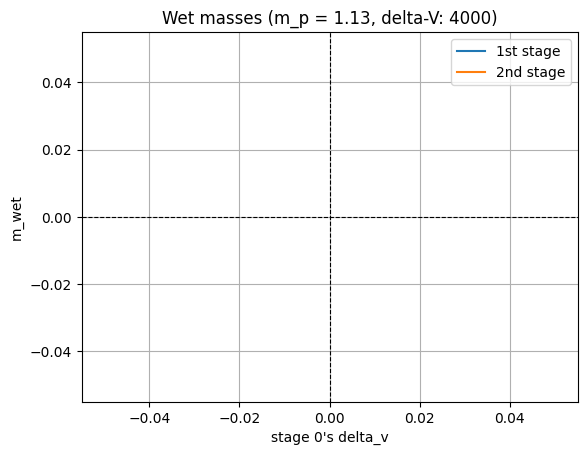

In [13]:
M_PAYLOAD = 1.13 # payload mass (tons) for stage 1 (upper)
DELTA_V = 4_000 # desired total delta V (m/s)

stage_0 = LiquidStage(SWIVEL)
stage_0.m_payload = M_PAYLOAD
stage_1 = DiscreteSolidStage(THUMPER)
rocket = Rocket([stage_0, stage_1])
plot_rocket(rocket, target_delta_v=DELTA_V)

In [8]:
rocket.set_delta_v_targets([3_500, 500])

print("Stage 0")
rocket.stages[0].print()

print("")
print("Stage 1")
rocket.stages[1].print()

Stage 0
target R: 4.2
actual R: 4.3
V_e: 2450.0
delta V: 3570.3
payload: 1.0
fuel: 14.0
struct: 1.8
dry mass: 4.2
wet mass: 18.2
TWR: 0.9

Stage 1
target R: 1.3
actual R: 1.3
V_e: 1715.0
delta V: 500.0
payload: 18.2
fuel: 7.2
struct: 3.0
dry mass: 21.2
wet mass: 28.4
TWR: 0.9
Rocket count: 2
